In [60]:
%reset -f

### Libraries

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn

from tqdm import tqdm

from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   RobustScaler,
                                   Normalizer,
                                   PolynomialFeatures,
                                   LabelEncoder,
                                   OneHotEncoder,
                                   OrdinalEncoder)

from sklearn.model_selection import (cross_val_score,
                                     KFold,
                                     StratifiedShuffleSplit,
                                     GridSearchCV,
                                     StratifiedKFold,
                                     cross_validate,
                                     train_test_split)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import (precision_score,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay)

from IPython.display import display
import warnings

warnings.filterwarnings("ignore")

In [62]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
submit = pd.read_csv('sample_submission.csv', index_col=0)

### Data preprocessing

In [63]:
# Сравнение столбцов
train_columns = set(train.columns)
test_columns = set(test.columns)

# Проверка наличия всех столбцов тренировочного набора в тестовом
if train_columns.issubset(test_columns):
    print("Все столбцы из тренировочного набора присутствуют в тестовом.")
else:
    missing_columns = train_columns - test_columns
    print("Отсутствующие столбцы в тестовом наборе данных:", missing_columns)

Отсутствующие столбцы в тестовом наборе данных: {'Machine failure'}


In [64]:
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features

['Product ID', 'Type']

In [65]:
for feature in cat_features:
    train_unique = set(train[feature].unique())
    test_unique = set(train[feature].unique())

    # Находим значения, которые есть в тестовом, но нет в тренировочном датасете
    diff = test_unique - train_unique
    if diff:
        print(
            f"В признаке '{feature}' следующие категории есть в тестовом датасете, но отсутствуют в тренировочном: {diff}")
    else:
        print(f"В признаке '{feature}' нет расхождений в категориях между тренировочным и тестовым датасетами.")

В признаке 'Product ID' нет расхождений в категориях между тренировочным и тестовым датасетами.
В признаке 'Type' нет расхождений в категориях между тренировочным и тестовым датасетами.


In [78]:
train.drop_duplicates(inplace=True)
# print(f"Удалено дубликатов: {train.shape[0] - train.drop_duplicates().shape[0]}")

In [66]:
RS = 42

In [ ]:
'''
class CustomTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def fit(self, df_source, y=None):
        return self

    def transform(self, df_source, y=None):
        df = df_source.copy()
        df['number'] = df['Product ID'].apply(lambda x: int(x[1:]))
        df.drop('Product ID', axis=1, inplace=True)
        return df
'''

### Feature engineering

In [75]:
x = train.drop('Machine failure', axis=1)
x['random'] = np.random.rand(x.shape[0], 1)

y = train['Machine failure']

cat_cols = ['Type']
num_cols = x.dtypes[x.dtypes != 'object'].index.to_list()

In [121]:
CT = ColumnTransformer([
    ("scaler", OrdinalEncoder(), cat_cols),
], remainder='passthrough')

#### XGB feature importance

In [89]:
pipe = Pipeline([('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('classifier', XGBClassifier(random_state=RS)),
                 ])

pipe.fit(x, y)

#feature_importances_ - это массив, где каждый элемент соответствует важности признака
feature_importances = pipe.__dict__['steps'][2][1].feature_importances_
feature_importances = pd.DataFrame(data=feature_importances, index=x.columns)
feature_importances.columns = ['importance']

feature_importances.sort_values('importance', ascending=False)

,importance
HDF,0.442613
OSF,0.274896
PWF,0.121720
TWF,0.119177
Rotational speed [rpm],0.008296
Torque [Nm],0.007086
Tool wear [min],0.005253
Air temperature [K],0.005091
Process temperature [K],0.004219
Product ID,0.004132


#### RFC feature importance

In [88]:
pipe = Pipeline([('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('classifier', RandomForestClassifier(random_state=RS)),
                 ])

pipe.fit(x, y)

#feature_importances_ - это массив, где каждый элемент соответствует важности признака
feature_importances = pipe.__dict__['steps'][2][1].feature_importances_
feature_importances = pd.DataFrame(data=feature_importances, index=x.columns)
feature_importances.columns = ['importance']

feature_importances.sort_values('importance', ascending=False)

,importance
HDF,0.271203
OSF,0.206016
PWF,0.103510
TWF,0.087880
Torque [Nm],0.076197
Rotational speed [rpm],0.058814
random,0.048383
Type,0.042595
Tool wear [min],0.038818
Air temperature [K],0.034268


In [113]:
del x['random']

#### Failure analysis

In [99]:
temp_df = train.iloc[:, -6:][train['Machine failure'] == 1].sum(axis=1)

# была поломка без причин / Machine Failure = 1; TWF, HDF, PWF, OSF, RNF = 0
failure_ixs = temp_df[temp_df == 1].index

# была поломка с причинами / Machine Failure = 1; TWF, HDF, PWF, OSF, RNF > 0
not_failure_ixs = temp_df[temp_df != 1].index

In [103]:
# изучим поломки без причин
df_1 = train[train.index.isin(failure_ixs)]
df_1.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.0,503.0,503.0,503.0,503.0,503.0
mean,300.358250,310.109344,1486.357853,47.170378,121.282306,1.0,0.0,0.0,0.0,0.0,0.0
std,2.029682,1.387800,268.843078,12.955505,72.976636,0.0,0.0,0.0,0.0,0.0,0.0
min,295.600000,306.000000,1183.000000,5.600000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0
25%,298.800000,309.100000,1356.500000,40.100000,58.000000,1.0,0.0,0.0,0.0,0.0,0.0
50%,300.500000,310.300000,1400.000000,48.300000,125.000000,1.0,0.0,0.0,0.0,0.0,0.0
75%,302.100000,311.000000,1510.000000,55.900000,192.000000,1.0,0.0,0.0,0.0,0.0,0.0
max,304.400000,313.600000,2833.000000,76.600000,246.000000,1.0,0.0,0.0,0.0,0.0,0.0


In [104]:
# изучим поломки с причинами
df_2 = train[train.index.isin(not_failure_ixs)]
df_2.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000,1626.0,1626.000000,1626.000000,1626.000000,1626.000000,1626.000000
mean,301.025215,310.337515,1442.605781,51.112054,136.420049,1.0,0.127921,0.428044,0.194957,0.325953,0.003690
std,1.973574,1.208852,287.139812,13.164085,73.404557,0.0,0.334105,0.494948,0.396289,0.468874,0.060652
min,295.600000,306.000000,1181.000000,3.800000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,299.400000,309.700000,1337.000000,46.625000,74.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,301.800000,310.500000,1365.000000,53.000000,159.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,302.500000,311.100000,1403.000000,59.100000,203.000000,1.0,0.000000,1.000000,0.000000,1.000000,0.000000
max,304.300000,313.600000,2886.000000,76.600000,253.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [153]:
temp_df = train[train.iloc[:,-5:].sum(axis=1) == 0]

temp_df['temperature_diff'] = abs(temp_df['Air temperature [K]'] - temp_df['Process temperature [K]'])

temp_df.groupby('Machine failure').agg({'temperature_diff': ['mean', 'median']})

temperature_diff       
                            mean median
Machine failure                        
0                      10.088775    9.9
1                       9.751093    9.7

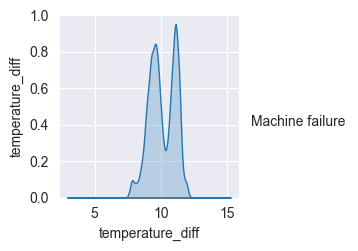

In [155]:
sns.pairplot(temp_df[['temperature_diff', 'Machine failure']], hue='Machine failure')

#### Making new features

In [164]:
# добавим фичу по разнице температур
x['temp_diff'] = x['Air temperature [K]'] - x['Process temperature [K]']
test['temp_diff'] = test['Air temperature [K]'] - test['Process temperature [K]']

In [115]:
# Добавим столбец с количеством поломок
x['failure_count'] = x.iloc[:, -5:-1].sum(axis=1)
test['failure_count'] = train.iloc[:, -5:-1].sum(axis=1)

In [167]:
# Вытаскиваем инфу из Product ID
# x['Product ID'] = x['Product ID'].apply(lambda x: int(x[1:]))
test['Product ID'] = test['Product ID'].apply(lambda x: int(x[1:]))

### Machine learning

In [180]:
cat_cols = ['Type']
num_cols = x.dtypes[x.dtypes != 'object'].index.to_list()

In [181]:
CT_tree = ColumnTransformer([
    ("encoder", OrdinalEncoder(), cat_cols),
    ], remainder='passthrough')

CT_linear = ColumnTransformer([
    ("encoder", OneHotEncoder(), cat_cols),
    ("poly", PolynomialFeatures(degree=3), num_cols)
    ], remainder='passthrough')

In [182]:
def grid_model(model, CT, n_splits=3, param_grid=[{}]):
    
    pipe = Pipeline([
                     ('preprocessing', CT),
                     ('scaler', StandardScaler()),
                     ('SMOTE', SMOTE(sampling_strategy=0.2, random_state=RS)),
                     ('classifier', model),
                     ])


    cross_val = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RS)
    
    grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                        return_train_score=True,
                        n_jobs=-1, scoring='roc_auc')
    
    grid.fit(x, y)
    display(pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T)

In [183]:
def predict_by_model(model, CT, test):
    
    pipe = Pipeline([
                     ('preprocessing', CT),
                     ('scaler', StandardScaler()),
                     ('SMOTE', SMOTE(sampling_strategy=0.2, random_state=RS)),
                     ('classifier', model),
                     ])
    
    pipe.fit(x,y)
    return pipe.predict(test)

In [184]:
model = XGBClassifier(max_depth=3, random_state=RS)
param_grid=[{
    # 'classifier__n_estimators': [10, 100, 300]
    # 'SMOTE__learning_rate': [0.1, 0.5, 0.9]
}]

grid_model(model, CT_tree)

,0
mean_fit_time,0.545909
std_fit_time,0.004612
mean_score_time,0.045303
std_score_time,0.000647
params,{}
split0_test_score,0.95683
split1_test_score,0.967863
split2_test_score,0.953313
mean_test_score,0.959335
std_test_score,0.006198


#### XGBoost

In [118]:
CT = ColumnTransformer([
    ("scaler", OrdinalEncoder(), cat_cols),
    ], remainder='passthrough')


pipe = Pipeline([
                 ('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('classifier', XGBClassifier(random_state=RS)),
                 ])

param_grid = [
    {
        
    }
]

cross_val = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)

grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                    return_train_score=True,
                    n_jobs=-1, scoring='roc_auc')

grid.fit(x, y)
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T

,0
mean_fit_time,0.54648
std_fit_time,0.002302
mean_score_time,0.078353
std_score_time,0.001081
params,{}
split0_test_score,0.953474
split1_test_score,0.966932
split2_test_score,0.957169
mean_test_score,0.959192
std_test_score,0.005677


#### Random Forest

In [122]:
pipe = Pipeline([
                 ('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('classifier', RandomForestClassifier(max_depth=3, random_state=RS)),
                 ])


param_grid = [
    {

    }
]

cross_val = StratifiedKFold(n_splits=3, shuffle=True, random_state=RS)

grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                    return_train_score=True,
                    n_jobs=-1, scoring='roc_auc')  # решетчатый пойск

grid.fit(x, y)
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T

,0
mean_fit_time,1.927848
std_fit_time,0.025117
mean_score_time,0.065821
std_score_time,0.003899
params,{}
split0_test_score,0.947829
split1_test_score,0.961969
split2_test_score,0.947791
mean_test_score,0.952529
std_test_score,0.006674


#### Logistic Regression

In [ ]:
pipe = Pipeline([
                 ('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('classifier', LogisticRegression(random_state=RS)),
                 ])

param_grid = [
    {

    }
]

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                    return_train_score=True,
                    n_jobs=-1, scoring='roc_auc')  # решетчатый пойск

grid.fit(x, y)
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T

#### SMOTE 

In [128]:
# LogisticRegression SMOTE
CT = ColumnTransformer([
    ("scaler", OneHotEncoder(), cat_cols),
    ("poly", PolynomialFeatures(degree=3), num_cols)],
    remainder='passthrough')

pipe = Pipeline([
                 ('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('SMOTE', SMOTE(random_state=RS)),
                 ('classifier', LogisticRegression(solver = 'liblinear', random_state=RS)),
                 ])

param_grid = [
    {
        # 'classifier__C': [0.1, 1, 10, 100, 1000]
    }
]

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                    return_train_score=True,
                    n_jobs=-1, scoring='roc_auc')  # решетчатый пойск

grid.fit(x, y)
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T

,0
mean_fit_time,282.320963
std_fit_time,20.51866
mean_score_time,0.294529
std_score_time,0.072539
params,{}
split0_test_score,0.956834
split1_test_score,0.951734
split2_test_score,0.964729
split3_test_score,0.941761
split4_test_score,0.960629


In [ ]:
# Random Forest SMOTE
CT = ColumnTransformer([
    ("scaler", OrdinalEncoder(), cat_cols),
    ("poly", PolynomialFeatures(degree=3), num_cols)
],
    remainder='passthrough')

pipe = Pipeline([('feature_id', CustomTransformer()),
                 ('preprocessing', CT),
                 ('scaler', StandardScaler()),
                 ('SMOTE', SMOTE(random_state=RS)),
                 ('classifier', RandomForestClassifier(max_depth=3, random_state=RS)),
                 ])

param_grid = [
    {

    }
]

cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

grid = GridSearchCV(pipe, param_grid, cv=cross_val,
                    return_train_score=True,
                    n_jobs=-1, scoring='roc_auc')  # решетчатый пойск

grid.fit(x, y)
pd.DataFrame(grid.cv_results_).sort_values(['rank_test_score'], ascending=[True]).T

### Final Submission

In [185]:
model = XGBClassifier(max_depth=3, random_state=RS)
prediction = predict_by_model(model, CT_tree, test)

In [ ]:
prediction

In [189]:
submit['Machine failure'] = prediction

In [190]:
submit.to_csv('XGB_feature_engineering.csv')

### EDA

In [ ]:
feature = ['Air temperature [K]', 'Process temperature [K]']
train[feature].hist(figsize=(10, 4))

In [ ]:
sns.boxplot(x='Torque [Nm]', data=train)

In [ ]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(6, 4))
sns.boxplot(data=train["Air temperature [K]"], ax=axes[0])
sns.violinplot(data=train["Air temperature [K]"], ax=axes[1]);

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.countplot(x="Torque [Nm]", data=train, ax=axes[0])
sns.countplot(x=y).set_xlabel('Machine failure');

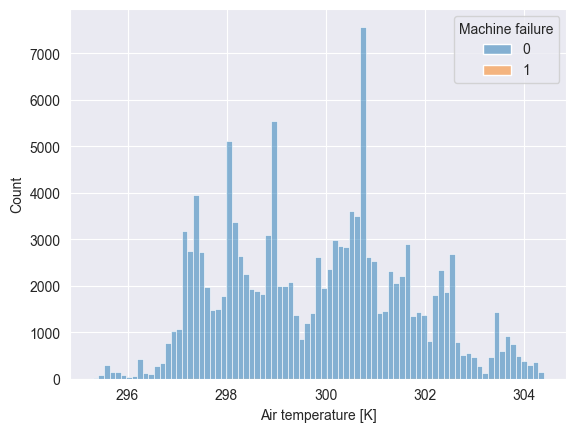

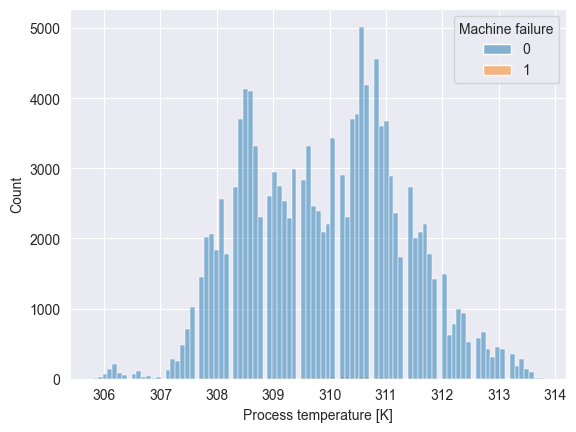

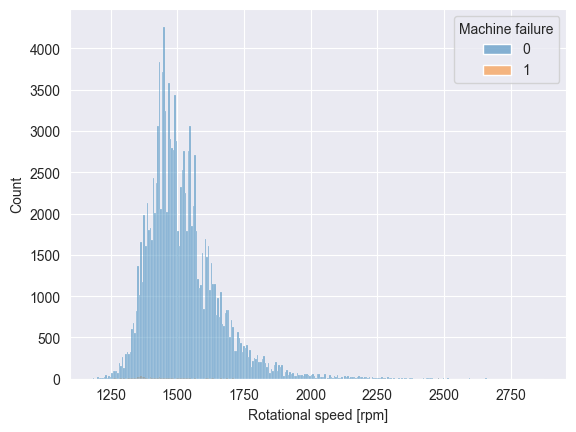

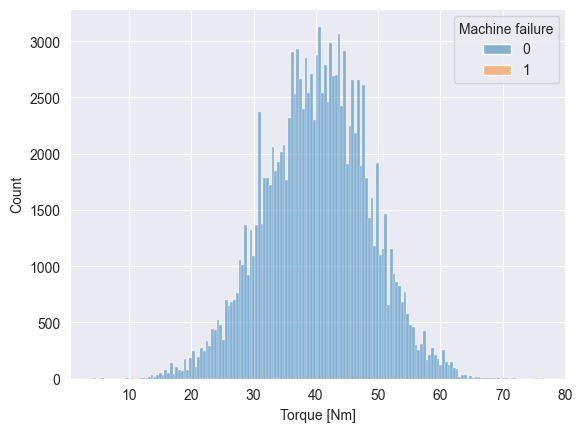

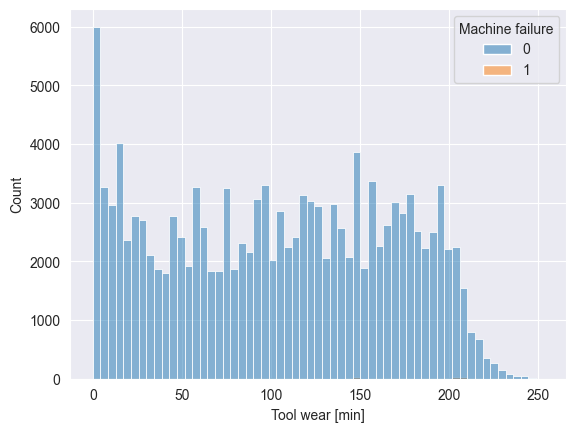

In [151]:
temp_df = train[train.iloc[:,-5:].sum(axis=1) == 0]
cols = temp_df.columns[2:-6]
for col in cols:   
    sns.histplot(data=temp_df, x=col, hue='Machine failure')
    plt.show()